In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/planet-understanding-the-amazon-from-space/Kaggle-planet-train-tif.torrent
/kaggle/input/planet-understanding-the-amazon-from-space/Kaggle-planet-test-tif.torrent
/kaggle/input/planet-understanding-the-amazon-from-space/test_v2_file_mapping.csv/test_v2_file_mapping.csv
/kaggle/input/planet-understanding-the-amazon-from-space/train_v2.csv/train_v2.csv
/kaggle/input/planet-understanding-the-amazon-from-space/sample_submission_v2.csv/sample_submission_v2.csv
/kaggle/input/kagglejson/kaggle.json
/kaggle/input/mlframework/LICENSE
/kaggle/input/mlframework/.gitignore
/kaggle/input/mlframework/README.md
/kaggle/input/mlframework/requirements.txt
/kaggle/input/mlframework/setup.py
/kaggle/input/mlframework/cnn/models.json
/kaggle/input/mlframework/cnn/model_builder.py
/kaggle/input/mlframework/cnn/__init__.py
/kaggle/input/mlframework/utils/metrics.py
/kaggle/input/mlframework/utils/file_utils.py
/kaggle/input/mlframework/utils/misc.py
/kaggle/input/mlframework/utils/charts.py
/k

### Install modules

In [2]:
! pip install livelossplot

In [3]:
! ls -ltar /kaggle/input/planet-understanding-the-amazon-from-space

total 2596
drwxr-xr-x 2 nobody nogroup       0 Jul 17 18:28 train_v2.csv
-rw-r--r-- 1 nobody nogroup 1055292 Jul 17 18:28 Kaggle-planet-train-tif.torrent
drwxr-xr-x 2 nobody nogroup       0 Jul 17 18:28 sample_submission_v2.csv
-rw-r--r-- 1 nobody nogroup 1594569 Jul 17 18:28 Kaggle-planet-test-tif.torrent
drwxr-xr-x 5 nobody nogroup       0 Jul 17 18:28 .
drwxr-xr-x 2 nobody nogroup       0 Jul 17 18:28 test_v2_file_mapping.csv
drwxr-xr-x 5 root   root       4096 Jul 27 13:12 ..



### Import the libraries

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow.keras as keras

import sys
sys.path.append('/kaggle/input/mlframework')

# import mlframework as xmf


### Extract the data from tar file
Need to configure the kaggle first, copy the credentials to ~/.kaggle folder

In [5]:
# Download the dataset 
if not os.path.isdir(os.path.join(os.path.expanduser('~'), '.kaggle')):
    os.mkdir(os.path.join(os.path.expanduser('~'), '.kaggle'))
    
DATA_DIR = '/kaggle/working/data'
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)
    
!cp /kaggle/input/kagglejson/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download nikitarom/planets-dataset -p '/kaggle/working/data'

planets-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


#### Unzip the files

In [6]:
# from utils.file_utils import unzip_file
# unzip_file(os.path.join(DATA_DIR, 'planets-dataset.zip'), DATA_DIR)

!unzip -q -n '/kaggle/working/data/planets-dataset.zip' -d '/kaggle/working/data'

In [7]:
DATA_DIR, os.path.join(DATA_DIR, 'planet', 'planet')

('/kaggle/working/data', '/kaggle/working/data/planet/planet')

In [8]:
INPUT_DIR = '/kaggle/input'
INPUT_DATA_DIR = '/kaggle/input/planet-understanding-the-amazon-from-space'
DATA_DIR = os.path.join(DATA_DIR, 'planet', 'planet')
TRAIN_DIR = os.path.join(DATA_DIR, 'train-jpg')
TEST_DIR  = os.path.join(DATA_DIR, 'test-jpg')

### Load data into pandas

Number of training images : 40479
Number of test images : 40669


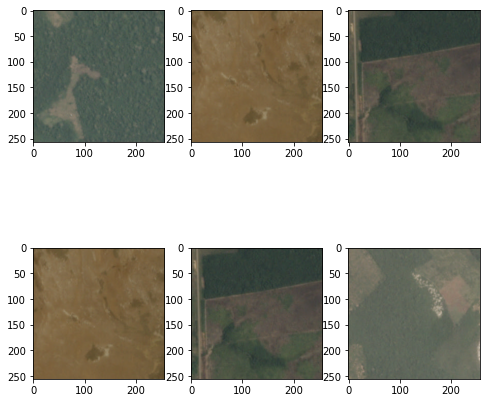

In [9]:
train_files = os.listdir(TRAIN_DIR)
test_files = os.listdir(TEST_DIR)

print(f'Number of training images : {len(train_files)}\nNumber of test images : {len(test_files)}')

import random
from utils.charts import plot_images

images = random.sample(train_files, 9)
images = [os.path.join(TRAIN_DIR, image) for image in images]
plot_images(images, row=2, col=3)

##### Create the tags dictionary

In [10]:
train_df = pd.read_csv(os.path.join(DATA_DIR,'train_classes.csv'))
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [12]:
test_df = pd.DataFrame(test_files, columns=['image_name'])
test_df.head() 

,image_name
0,test_18154.jpg
1,test_2671.jpg
2,test_12521.jpg
3,test_3094.jpg
4,test_25461.jpg


In [13]:
# Create a dictionary for the tags
tags = train_df['tags'].str.split(' ').explode().unique().tolist()
print(f'Total number of tags : {len(tags)}')

# create a dictionary for the tags
tags_dict = dict()
for i, tag in enumerate(tags):
    tags_dict[i] = tag

tags_dict

Total number of tags : 17


{0: 'haze',
 1: 'primary',
 2: 'agriculture',
 3: 'clear',
 4: 'water',
 5: 'habitation',
 6: 'road',
 7: 'cultivation',
 8: 'slash_burn',
 9: 'cloudy',
 10: 'partly_cloudy',
 11: 'conventional_mine',
 12: 'bare_ground',
 13: 'artisinal_mine',
 14: 'blooming',
 15: 'selective_logging',
 16: 'blow_down'}

In [14]:
# Convert the tags from list to One-hot encoder array
tags = train_df['tags'].str.split(' ')
from sklearn.preprocessing import MultiLabelBinarizer
lb = MultiLabelBinarizer()
encoded = lb.fit_transform(tags)
encoded

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [15]:
one_hot_df = pd.DataFrame(encoded, columns=lb.classes_, dtype=int, index=train_df.index)
df = pd.concat([train_df, one_hot_df], axis=1)
df['image_name'] = df['image_name'].apply(lambda x: f'{x}.jpg')

from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size=0.1, shuffle=True)
len(train_df), len(valid_df)

y_cols = df.columns.tolist()[2:]
y_cols

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [16]:
df.head()

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0.jpg,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1.jpg,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


##### Define the Generators and callbacks

In [23]:
from keras.preprocessing.image import ImageDataGenerator

INPUT_SHAPE = (224, 224, 3)
train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True,
                                   vertical_flip=True, zoom_range=0.5, rotation_range=90)
valid_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = train_datagen.flow_from_dataframe(train_df, directory=TRAIN_DIR,
                                              x_col='image_name', y_col=y_cols, 
                                             batch_size=64, class_mode='raw',
                                             target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]))

valid_gen = valid_datagen.flow_from_dataframe(valid_df, directory=TRAIN_DIR,
                                              x_col='image_name', y_col=y_cols, 
                                             batch_size=64, class_mode='raw',
                                             target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]))

test_gen = valid_datagen.flow_from_dataframe(test_df, directory=TEST_DIR,
                                              x_col='image_name', y_col=None, 
                                             batch_size=64, class_mode=None)

Found 36431 validated image filenames.
Found 4048 validated image filenames.
Found 40669 validated image filenames.


In [18]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from livelossplot.inputs.keras import PlotLossesCallback

es = EarlyStopping(monitor="val_accuracy",patience=4)
weight_filepath = 'vgg_block_weight_best.hdf'
ckpt= ModelCheckpoint(
    filepath=weight_filepath,
    save_weights_only=True,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, cooldown=2, verbose=1)
plot_loss = PlotLossesCallback()

### Create base model from scratch

In [19]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.models import Model, Sequential
from keras.optimizers import Adam

from cnn.model_builder import get_vgg_block


base_cnn = get_vgg_block(3, input_shape=INPUT_SHAPE)

model = base_cnn
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer="he_uniform"))
model.add(Dense(256, activation='relu', kernel_initializer="he_uniform"))
model.add(Dropout(0.2))
model.add(Dense(17, activation='sigmoid'))
model.summary()

model.compile(optimizer=Adam(lr=0.0001),loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       7

In [ ]:
history = model.fit(train_gen, validation_data=valid_gen,
                    epochs=25, callbacks=[es, ckpt, lr, plot_loss],
                    verbose=1)
result_df = pd.DataFrame(history.history)
result_df.head()

Epoch 1/25
 45/570 [=>............................] - ETA: 7:07 - loss: 0.3422 - accuracy: 0.0233

### Create Model from pretrained

In [ ]:
from keras.applic